#### Ashim Nepal | L6CG9
#### Worksheet 05

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report

## Task-1: Data Understanding and Visualization:

### A. Load and visualize images from a dataset stored in directories, where each subdirec-tory represents a class.

In [60]:
train_dir = "/content/drive/MyDrive/Sem6/AI_ML/week_5/FruitinAmazon/train"
test_dir = "/content/drive/MyDrive/Sem6/AI_ML/week_5/FruitinAmazon/test"

Number of classes: 6
Class names: ['cupuacu', 'graviola', 'guarana', 'acai', 'pupunha', 'tucuma']


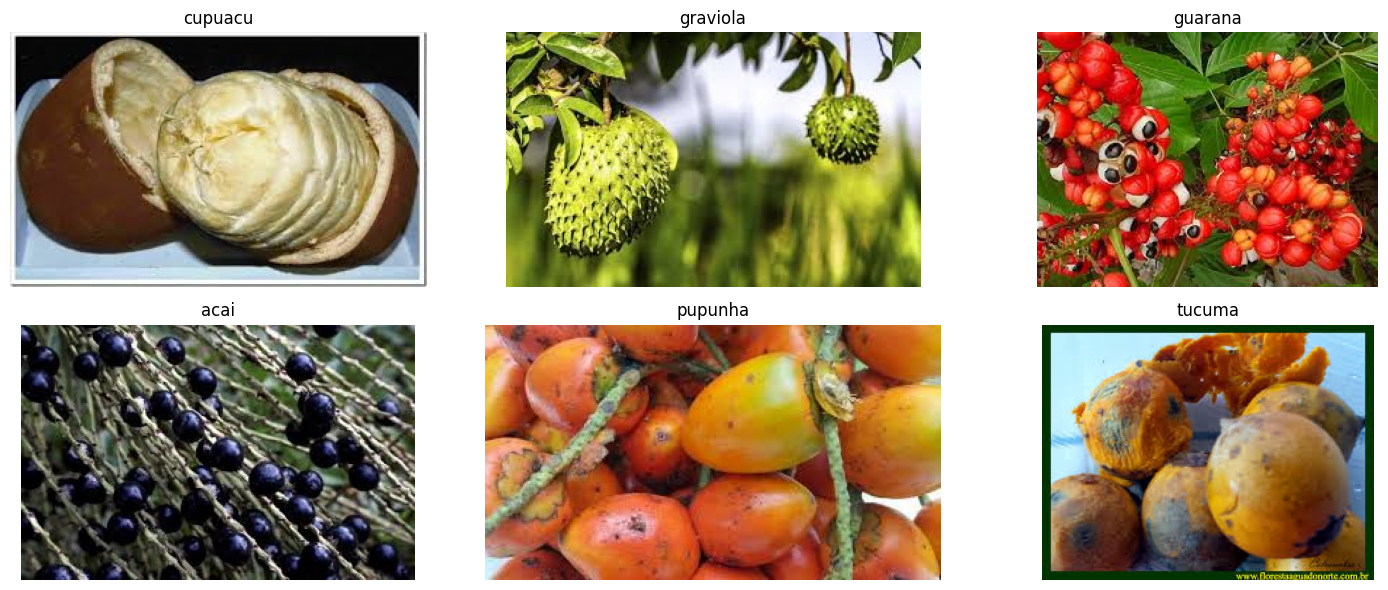

In [61]:
class_dirs = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
class_names = class_dirs
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

# Select one random image from each class
images = []
for class_dir in class_dirs:
    class_path = os.path.join(train_dir, class_dir)
    image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    if image_files:
        random_image = random.choice(image_files)
        image_path = os.path.join(class_path, random_image)
        images.append(image_path)

columns = (num_classes + 1) // 2
fig, axes = plt.subplots(2, columns, figsize=(15, 6))
axes = axes.flatten()

# Plot each image
for i, image_path in enumerate(images):
    img = Image.open(image_path)
    axes[i].imshow(img)
    axes[i].set_title(class_names[i])
    axes[i].axis('off')

# Hide any unused axes if num_classes is odd
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### B. Checking for Corrupted Image

In [62]:
def check_and_remove_corrupted_images(directory):
    corrupted_images = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(root, file)
                try:
                    img = Image.open(image_path)
                    img.verify()  # Verify the image integrity
                except (IOError, SyntaxError) as e:
                    print(f"Removed corrupted image: {image_path}")
                    os.remove(image_path)
                    corrupted_images.append(image_path)
    if not corrupted_images:
        print("No corrupted images found.")
    else:
        print(f"Total corrupted images removed: {len(corrupted_images)}")

# Run the check on the train directory
check_and_remove_corrupted_images(train_dir)

No corrupted images found.


# Task 2: Loading and Preprocessing Image Data in keras

In [63]:
# Define image size and batch size
img_height = 128
img_width = 128
batch_size = 16

# Load training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    label_mode='categorical',
    seed=123
)

# Load test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
)

# Verify class names and number of classes
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")


# Applying normalization to scale pixel values to [0,1]
rescale = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (rescale(x), y))
test_ds = test_ds.map(lambda x, y: (rescale(x), y))


for images, labels in train_ds.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels sample:", labels.numpy())
    break


Found 90 files belonging to 6 classes.
Found 30 files belonging to 6 classes.
Class names: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']
Number of classes: 6
Images shape: (16, 128, 128, 3)
Labels shape: (16, 6)
Labels sample: [[0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]]


# Task 3: Implement a CNN with given Structure and Hyper - parameters:

In [64]:
model = keras.Sequential([
    # Convolutional Layer 1
    layers.Conv2D(32, (3, 3), padding='same', strides=1, activation='relu',
                  input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2), strides=2),
    # Convolutional Layer 2
    layers.Conv2D(32, (3, 3), padding='same', strides=1, activation='relu'),
    layers.MaxPooling2D((2, 2), strides=2),
    # Fully Connected Layers
    layers.Flatten(),
    layers.Dense(64, activation='relu'),  # First hidden layer
    layers.Dense(128, activation='relu'),   # Second hidden layer
    layers.Dense(num_classes, activation='softmax')  # Output layer
])

# Display model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

# Task 4: Compile the Model

In [65]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Task 4: Train the Model

In [66]:
# Define callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    train_ds,
    epochs=250,
    validation_data=test_ds,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.0891 - loss: 1.9536

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 425ms/step - accuracy: 0.0906 - loss: 1.9523 - val_accuracy: 0.2000 - val_loss: 1.8260
Epoch 2/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.2135 - loss: 1.7723

6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 444ms/step - accuracy: 0.2179 - loss: 1.7686 - val_accuracy: 0.4667 - val_loss: 1.7040
Epoch 3/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 327ms/step - accuracy: 0.4551 - loss: 1.6300 - val_accuracy: 0.3667 - val_loss: 1.5107
Epoch 4/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 334ms/step - accuracy: 0.5602 - loss: 1.3346 - val_accuracy: 0.3667 - val_loss: 1.4058
Epoch 5/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 338ms/step - accuracy: 0.7286 - loss: 1.0992 - val_accuracy: 0.4667 - val_loss: 1.2006
Epoch 6/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.7189 - loss: 0.8404

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 610ms/step - accuracy: 0.7305 - loss: 0.8278 - val_accuracy: 0.7000 - val_loss: 0.8597
Epoch 7/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 341ms/step - accuracy: 0.9358 - loss: 0.4557 - val_accuracy: 0.6667 - val_loss: 0.9314
Epoch 8/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 336ms/step - accuracy: 0.9380 - loss: 0.3437 - val_accuracy: 0.7000 - val_loss: 1.0051
Epoch 9/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 326ms/step - accuracy: 0.9484 - loss: 0.2379 - val_accuracy: 0.6000 - val_loss: 0.9417
Epoch 10/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 375ms/step - accuracy: 0.9950 - loss: 0.0864 - val_accuracy: 0.6000 - val_loss: 1.1695
Epoch 11/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 598ms/step - accuracy: 0.9898 - loss: 0.0686 - val_accuracy: 0.6333 - val_loss: 1.2066
Epoch 12/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.9744 - loss: 0.0683

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 358ms/step - accuracy: 0.9764 - loss: 0.0672 - val_accuracy: 0.7333 - val_loss: 0.9073
Epoch 13/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 345ms/step - accuracy: 1.0000 - loss: 0.0300 - val_accuracy: 0.6333 - val_loss: 0.8855
Epoch 14/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 347ms/step - accuracy: 1.0000 - loss: 0.0233 - val_accuracy: 0.7000 - val_loss: 0.9232
Epoch 15/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 430ms/step - accuracy: 1.0000 - loss: 0.0129 - val_accuracy: 0.6667 - val_loss: 1.0810
Epoch 16/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 561ms/step - accuracy: 1.0000 - loss: 0.0087 - val_accuracy: 0.7333 - val_loss: 0.8188
Epoch 17/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 345ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.7000 - val_loss: 0.7834
Epoch 18/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 1.0000 - loss: 0.0025

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 353ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.7667 - val_loss: 0.7534
Epoch 19/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 352ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.7333 - val_loss: 0.7393
Epoch 20/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 416ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.7333 - val_loss: 0.7756
Epoch 21/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 566ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.7333 - val_loss: 0.8140
Epoch 22/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 345ms/step - accuracy: 1.0000 - loss: 8.8349e-04 - val_accuracy: 0.7333 - val_loss: 0.8444
Epoch 23/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 339ms/step - accuracy: 1.0000 - loss: 7.1183e-04 - val_accuracy: 0.7333 - val_loss: 0.8731
Epoch 24/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 343ms/step - accuracy: 1.0000 - loss: 6.9234e-04 - val_accuracy: 0.7333 - val_loss: 0.8972
Epoch 25/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 394ms/step - accuracy: 1.0000 - loss: 6.6209e-04 - val_accuracy:

# Task 5: Evaluate the Model


In [67]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7597 - loss: 0.6383
Test accuracy: 0.7333
Test loss: 0.7393


# Task 6: Save and Load the Model

In [68]:
model.save('AshimNepal_w5.h5')
print("Model saved as 'AshimNepal_w5.h5'")

Model saved as 'AshimNepal_w5.h5'


In [69]:
loaded_model = tf.keras.models.load_model('AshimNepal_w5.h5')
loaded_test_loss, loaded_test_acc = loaded_model.evaluate(test_ds)
print(f"Loaded model test accuracy: {loaded_test_acc:.4f}")
print(f"Loaded model test loss: {loaded_test_loss:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.7597 - loss: 0.6383
Loaded model test accuracy: 0.7333
Loaded model test loss: 0.7393


# Task 7: Predictions and Classification Report


In [70]:
loaded_model = keras.models.load_model('AshimNepal_w5.h5')
print("Model loaded for predictions")

# Collect all test images and labels
all_images = []
all_labels = []
for images, labels in test_ds:
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

# Concatenate batches into single arrays
test_images = np.concatenate(all_images, axis=0)  # Shape: (30, 128, 128, 3)
test_labels_onehot = np.concatenate(all_labels, axis=0)  # Shape: (30, 6)

# Make predictions
predictions = loaded_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels_onehot, axis=1)


print(f"Class names: {class_names}")

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:\n", report)

Model loaded for predictions
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
Class names: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']
Classification Report:
               precision    recall  f1-score   support

        acai       0.80      0.80      0.80         5
     cupuacu       0.43      0.60      0.50         5
    graviola       0.71      1.00      0.83         5
     guarana       1.00      0.80      0.89         5
     pupunha       0.80      0.80      0.80         5
      tucuma       1.00      0.40      0.57         5

    accuracy                           0.73        30
   macro avg       0.79      0.73      0.73        30
weighted avg       0.79      0.73      0.73        30

